In [1]:
import torch
import transformer_lens
import circuitsvis as cv
import numpy as np
import matplotlib.pylab as plt
import torch.nn.functional as F
r = torch.set_grad_enabled(False)
# https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Main_Demo.ipynb#scrollTo=-A6QnlzFpH3o

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load a model (eg GPT-2 Small)
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-small")

Loaded pretrained model gpt2-small into HookedTransformer


In [3]:
# Get model configuration
print(model.cfg)

HookedTransformerConfig:
{'act_fn': 'gelu_new',
 'attention_dir': 'causal',
 'attn_only': False,
 'attn_types': None,
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'd_head': 64,
 'd_mlp': 3072,
 'd_model': 768,
 'd_vocab': 50257,
 'd_vocab_out': 50257,
 'decoder_start_token_id': None,
 'default_prepend_bos': True,
 'device': device(type='cpu'),
 'dtype': torch.float32,
 'eps': 1e-05,
 'experts_per_token': None,
 'final_rms': False,
 'from_checkpoint': False,
 'gated_mlp': False,
 'init_mode': 'gpt2',
 'init_weights': False,
 'initializer_range': 0.02886751345948129,
 'load_in_4bit': False,
 'model_name': 'gpt2',
 'n_ctx': 1024,
 'n_devices': 1,
 'n_heads': 12,
 'n_key_value_heads': None,
 'n_layers': 12,
 'n_params': 84934656,
 'normalization_type': 'LNPre',
 'num_experts': None,
 'original_architecture': 'GPT2LMHeadModel',
 'parallel_attn_mlp': False,
 'positional_embedding_type': 'standard',
 'post_embedding_ln': False,
 'relative_attention_ma

-------------------
## Model parameters

In [95]:
# Print layer-specific parameters
layer_index = 0
print(f"Layer {layer_index} parameters:")
print("--------------------------------")
for name, param in model.named_parameters():
    if name.startswith(f"blocks.{layer_index}."):
        print(name, param.shape)

Layer 0 parameters:
--------------------------------
blocks.0.attn.W_Q torch.Size([12, 768, 64])
blocks.0.attn.W_O torch.Size([12, 64, 768])
blocks.0.attn.b_Q torch.Size([12, 64])
blocks.0.attn.b_O torch.Size([768])
blocks.0.attn.W_K torch.Size([12, 768, 64])
blocks.0.attn.W_V torch.Size([12, 768, 64])
blocks.0.attn.b_K torch.Size([12, 64])
blocks.0.attn.b_V torch.Size([12, 64])
blocks.0.mlp.W_in torch.Size([768, 3072])
blocks.0.mlp.b_in torch.Size([3072])
blocks.0.mlp.W_out torch.Size([3072, 768])
blocks.0.mlp.b_out torch.Size([768])


In [98]:
# Print embedding and unembeddin parameters
print(f"Embedding and unembedding parameters:")
print("--------------------------------")
for name, param in model.named_parameters():
    if "embed" in name:
        print(name, param.shape)

Embedding and unembedding parameters:
--------------------------------
embed.W_E torch.Size([50257, 768])
pos_embed.W_pos torch.Size([1024, 768])
unembed.W_U torch.Size([768, 50257])
unembed.b_U torch.Size([50257])


In [101]:
# Print total number of parameters
print(f"Total number of parameters = {model.cfg.n_params}")

Total number of parameters = 84934656


-------------------------------------
## Running the model

In [4]:
# Define input sequence for model
input_text_sequence = "Paris is the capital city of"

In [42]:
# Tokenise input sequence
prepend_bos = True # "Beginning of String" token
input_text_tokens = model.to_tokens(input_text_sequence, prepend_bos=prepend_bos)
input_text_str_tokens = model.to_str_tokens(input_text_sequence, prepend_bos=prepend_bos)
n_input_tokens = input_text_tokens.shape[1]
print(input_text_str_tokens)
print(input_text_tokens)
print(f"Total number of tokens = {n_input_tokens}")


['<|endoftext|>', 'Paris', ' is', ' the', ' capital', ' city', ' of']
tensor([[50256, 40313,   318,   262,  3139,  1748,   286]])
Total number of tokens = 7


In [6]:
# Run the model and get logits and activations
logits, activations = model.run_with_cache(input_text_tokens, remove_batch_dim=True)

-----------------------------
## Logit predictions

In [7]:
# Output model predictions for each prefix
for t in range(n_input_tokens):
    input_tok, output_tok = input_text_tokens[:,t], logits[:,t,:].argmax(axis=1)
    input_str, output_str = [model.tokenizer.decode(tok) for tok in [input_tok, output_tok]]
    print(f"{t}: '{input_str}' --> '{output_str}'")

0: '<|endoftext|>' --> '
'
1: 'Paris' --> ','
2: ' is' --> ' a'
3: ' the' --> ' capital'
4: ' capital' --> ' of'
5: ' city' --> ' of'
6: ' of' --> ' France'


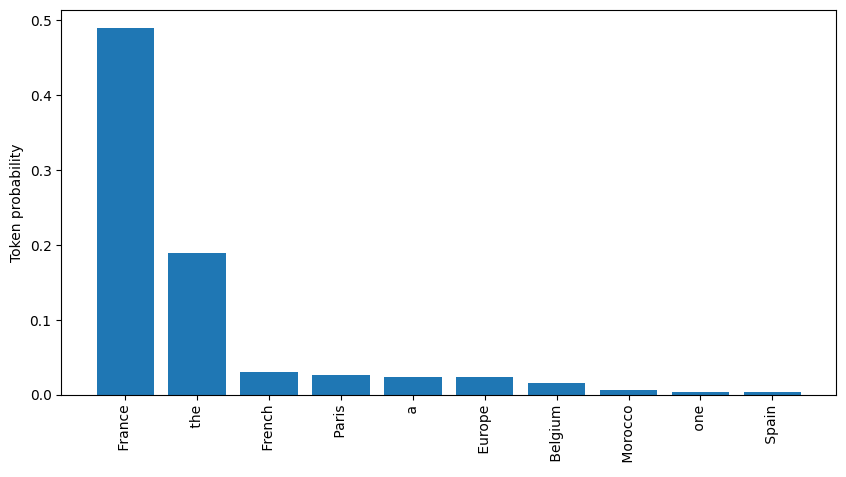

In [8]:
# Look up top n final string predictions
n_words_to_predict = 10
next_token_predictions = np.argsort(logits[0,-1,:])
next_token_probabilitites = F.softmax(logits[:,-1,next_token_predictions], dim=-1)
strings, probabilities = [], []
for p in range(1,n_words_to_predict+1):
    tok = next_token_predictions[-p]
    str_, prob = model.tokenizer.decode(tok), next_token_probabilitites[0,-p].tolist()
    strings.append(str_)
    probabilities.append(prob)

# Plot words and probabilities
fig = plt.figure(figsize=(10,5))
Xs = np.arange(n_words_to_predict)
r = plt.bar(Xs, probabilities)
r = plt.xticks(Xs, strings, rotation='vertical')
r = plt.ylabel("Token probability")


-------------------------
## Residual stream

In [9]:
# Get the accumulated residual stream at each layer/sub-layer
accum_resid, labels = activations.accumulated_resid(return_labels=True, apply_ln=True)
last_token_accum = accum_resid[:, -1, :]  # layer, batch, pos, d_model

In [10]:
# Unembed token predictions
W_U = model.W_U
unembedded_last_token_accum = torch.einsum('ld, dv -> lv', last_token_accum, W_U)

In [12]:
# Apply softmax to each layer
for layer in range(model.cfg.n_layers):
    unembedded_last_token_accum[layer] = F.softmax(unembedded_last_token_accum[layer], dim=-1)

In [15]:
# Show final tokens predicted at each layer
n_tokens_to_display = 5
for layer in range(model.cfg.n_layers):
    tokens = np.argsort(unembedded_last_token_accum[layer,:])[-n_tokens_to_display:]
    token_probs = [int(r.tolist()*100) for r in unembedded_last_token_accum[layer,tokens]][::-1]
    str_ = [model.tokenizer.decode(tok) for tok in tokens][::-1]
    print(f"Layer {layer}:" + ",".join([f"{s} ({p}%)" for s,p in zip(str_, token_probs)]))

Layer 0: destro (0%), mathemat (0%), challeng (0%),theless (0%), arrang (0%)
Layer 1: course (0%), the (0%), sorts (0%), Commerce (0%), mend (0%)
Layer 2: course (0%), the (0%), sorts (0%), honor (0%), late (0%)
Layer 3: course (0%), the (0%), its (0%), sorts (0%), ours (0%)
Layer 4: Dam (0%), Towns (0%), course (0%), popular (0%), Refuge (0%)
Layer 5: Towns (0%), Gran (0%), Refuge (0%), Hope (0%), popular (0%)
Layer 6: Governors (0%), southwest (0%), northwest (0%), town (0%), Aqu (0%)
Layer 7: southwest (0%), northwest (0%), Governors (0%), northeast (0%), southeast (0%)
Layer 8: southwest (0%), British (0%), Governors (0%), northeastern (0%), northeast (0%)
Layer 9: France (0%), Europe (0%), Latin (0%), Belgium (0%), French (0%)
Layer 10: France (6%), Europe (2%), Belgium (1%), French (1%), Latin (0%)
Layer 11: France (48%), Belgium (5%), Europe (3%), Morocco (2%), French (2%)


In [ ]:
# # Get most important network component
# residual_stream, labels = activations.decompose_resid(return_labels=True, mode="attn")
# answer = " France" # Note the proceeding space to match the model's tokenization
# logit_attrs = activations.logit_attrs(residual_stream, answer)
# most_important_component_idx = torch.argmax(logit_attrs)-1
# print(len(labels))
# print(labels[most_important_component_idx])

-----------
## Activations

<b>Note:</b> LayerNorm is applied every time a layer reads from the residual stream: `ln1` is the LayerNorm before the attention layer in a block, `ln2` the one before the MLP layer, and `ln_final` is the LayerNorm before the unembed.

In [17]:
# Define function to activations for each layer
def getLayerActivations(activations, layer):
    # Pre-attention
    residual_pre = activations[f"blocks.{layer}.hook_resid_pre"]
    layer_norm_1 = {k: activations[f"blocks.{layer}.ln1.hook_{k}"] for k in ["scale","normalized"]}
    # Attention
    attention = {k: activations[f"blocks.{layer}.attn.hook_{k}"] for k in ["q","k","v","attn_scores","pattern","z"]}
    attention["out"] = activations[f"blocks.{layer}.hook_attn_out"]
    # Pre-MLP
    residual_mid = activations[f"blocks.{layer}.hook_resid_mid"]
    layer_norm_2 = {k: activations[f"blocks.{layer}.ln2.hook_{k}"] for k in ["scale","normalized"]}
    # MLP
    mlp = {k: activations[f"blocks.{layer}.mlp.hook_{k}"] for k in ["pre","post"]}
    mlp["out"] = activations[f"blocks.{layer}.hook_mlp_out"]
    # Output
    residual_post = activations[f"blocks.{layer}.hook_resid_post"]
    return residual_pre, layer_norm_1, attention, residual_mid, layer_norm_2, mlp, residual_post

In [18]:
# Get embeddings
token_embeddings = activations["hook_embed"]
positional_embedding = activations["hook_pos_embed"]

# Get layer activations
layer_activations = {}
for n in range(model.cfg.n_layers):
    layer_activations[n] = getLayerActivations(activations, n)

# Get final layer norm
layer_norm_final = {k: activations[f"ln_final.hook_{k}"] for k in ["scale","normalized"]}

In [19]:
# This works for some reason
layer_index = 0
activation = "attn"
attention_pattern = activations["pattern", layer_index, activation]

-------------------------------------
## Attention

In [ ]:
# Get attention parameters
n_heads, d_head = [getattr(model.cfg, attr) for attr in ["n_heads","d_head"]]
print(f"N heads = {n_heads}, D heads = {d_head}")

N heads = 12, D heads = 64


In [ ]:
# Get activations for a single layer
layer_index = 0
residual_pre, layer_norm_1, attention, residual_mid, layer_norm_2, mlp, residual_post = layer_activations[layer_index]
q, k, v, attn_scores, pattern, z, out = [attention[k] for k in attention.keys()]

#### Compute attention scores for a single head

In [ ]:
# Define Q and K matrices
head_idx = 0
Q = q[:,head_idx,:]
K = k[:,head_idx,:]
V = v[:,head_idx,:]

# Step 1: Compute the dot product of Q and K^T to get the raw attention scores (we need to transpose K for the dot product)
raw_scores = torch.matmul(Q, K.T)

# Step 2: Scale the raw scores by the square root of the dimension of the keys (64 in this case)
scaled_scores = raw_scores / torch.sqrt(torch.tensor(d_head, dtype=torch.float32))

# Step 3: Create an upper triangular mask
seq_len = scaled_scores.size(-1)
mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()

# Apply the mask to the scaled scores
scaled_scores.masked_fill_(mask, float('-inf'))

# Check the calculation
if np.allclose(scaled_scores, attn_scores[head_idx]):
    print("Computed attention scores are the same as in the model!")

Computed attention scores are the same as in the model!


#### Compute attention pattern from attention scores

In [ ]:
# Apply the softmax function to get the attention weights
attention_pattern = F.softmax(scaled_scores, dim=-1)

# Check the calculation
if np.allclose(attention_pattern, pattern[head_idx]):
    print("Computed attention pattern is the same as in the model!")

Computed attention pattern is the same as in the model!


#### View attention patterns in attention heads (of a given layer)

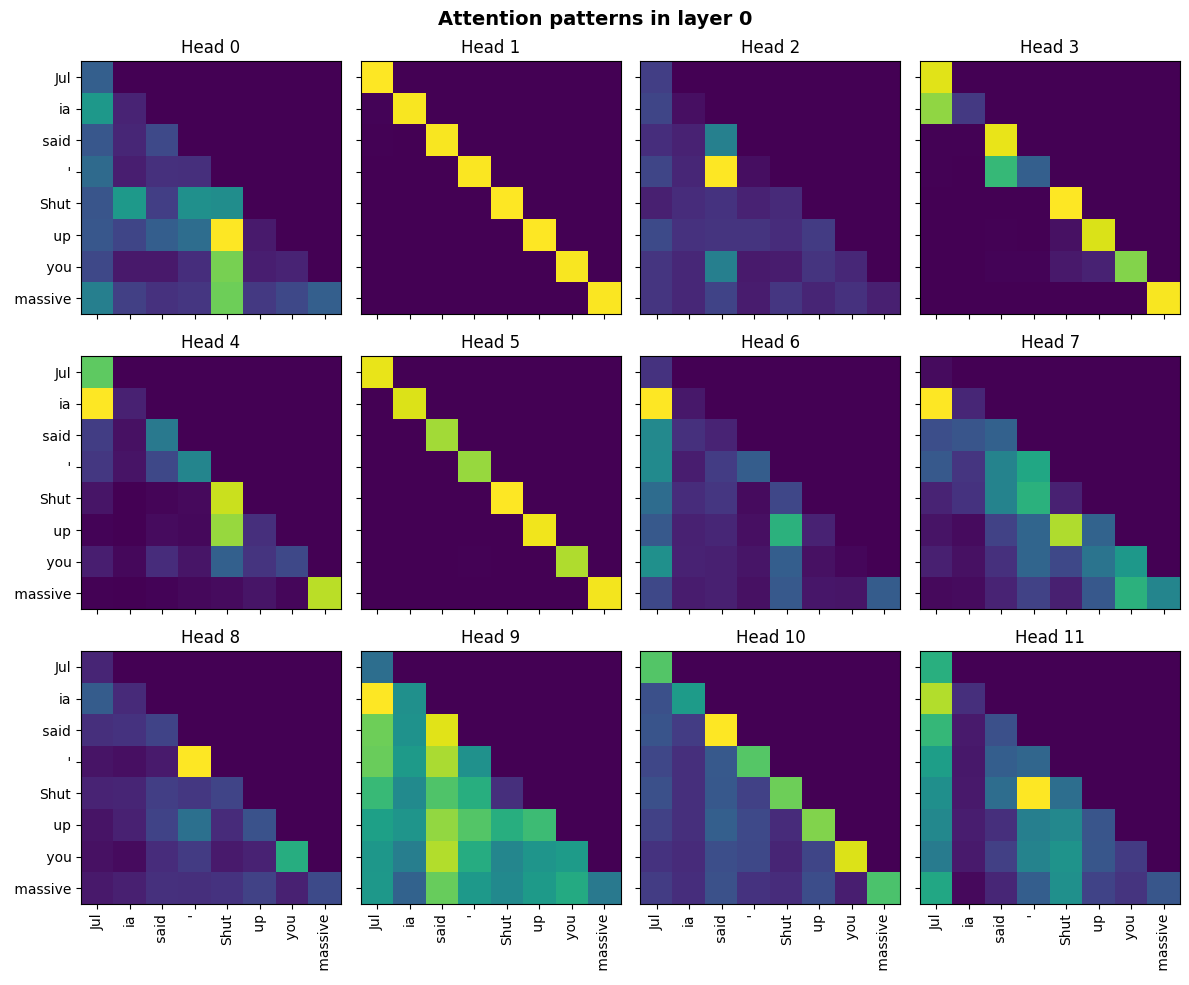

In [ ]:
# With matplotlib
n_rows = 3
fig,ax = plt.subplots(n_rows, n_heads//n_rows,sharex=True,sharey=True,figsize=(12,10))
ax = ax.flatten()
for h in range(n_heads):
    ax[h].imshow(pattern[h][1:,1:], aspect="auto", origin="upper")
    ax[h].set_title(f"Head {h}")
    ax[h].set_xticks(np.arange(n_input_tokens-1), input_text_str_tokens[1:], rotation="vertical")
    ax[h].set_yticks(np.arange(n_input_tokens-1), input_text_str_tokens[1:], rotation="horizontal")

plt.suptitle(f"Attention patterns in layer {layer_index}", fontsize=14, fontweight="bold")
plt.tight_layout()

In [ ]:
# With circuitsvis
cv.attention.attention_patterns(tokens=input_text_str_tokens[1:], attention=pattern[:,1:,1:])

-------------------------------------
## Multi-layer perceptron

In [20]:
# Get MLP parameters
d_mlp, d_model = [getattr(model.cfg, attr) for attr in ["d_mlp","d_model"]]
print(f"MLP dimension = {d_mlp}, Model dimension = {d_model}")

MLP dimension = 3072, Model dimension = 768


Text(0, 0.5, 'Post')

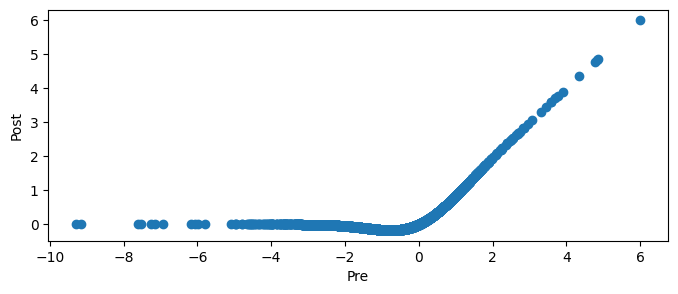

In [90]:
# The "post_nonlinear" data is the "pre_nonlinear" data passed through a GELU
fig = plt.figure(figsize=(8,3))
plt.scatter(pre_nonlinear, post_nonlinear)
plt.xlabel("Pre")
plt.ylabel("Post")

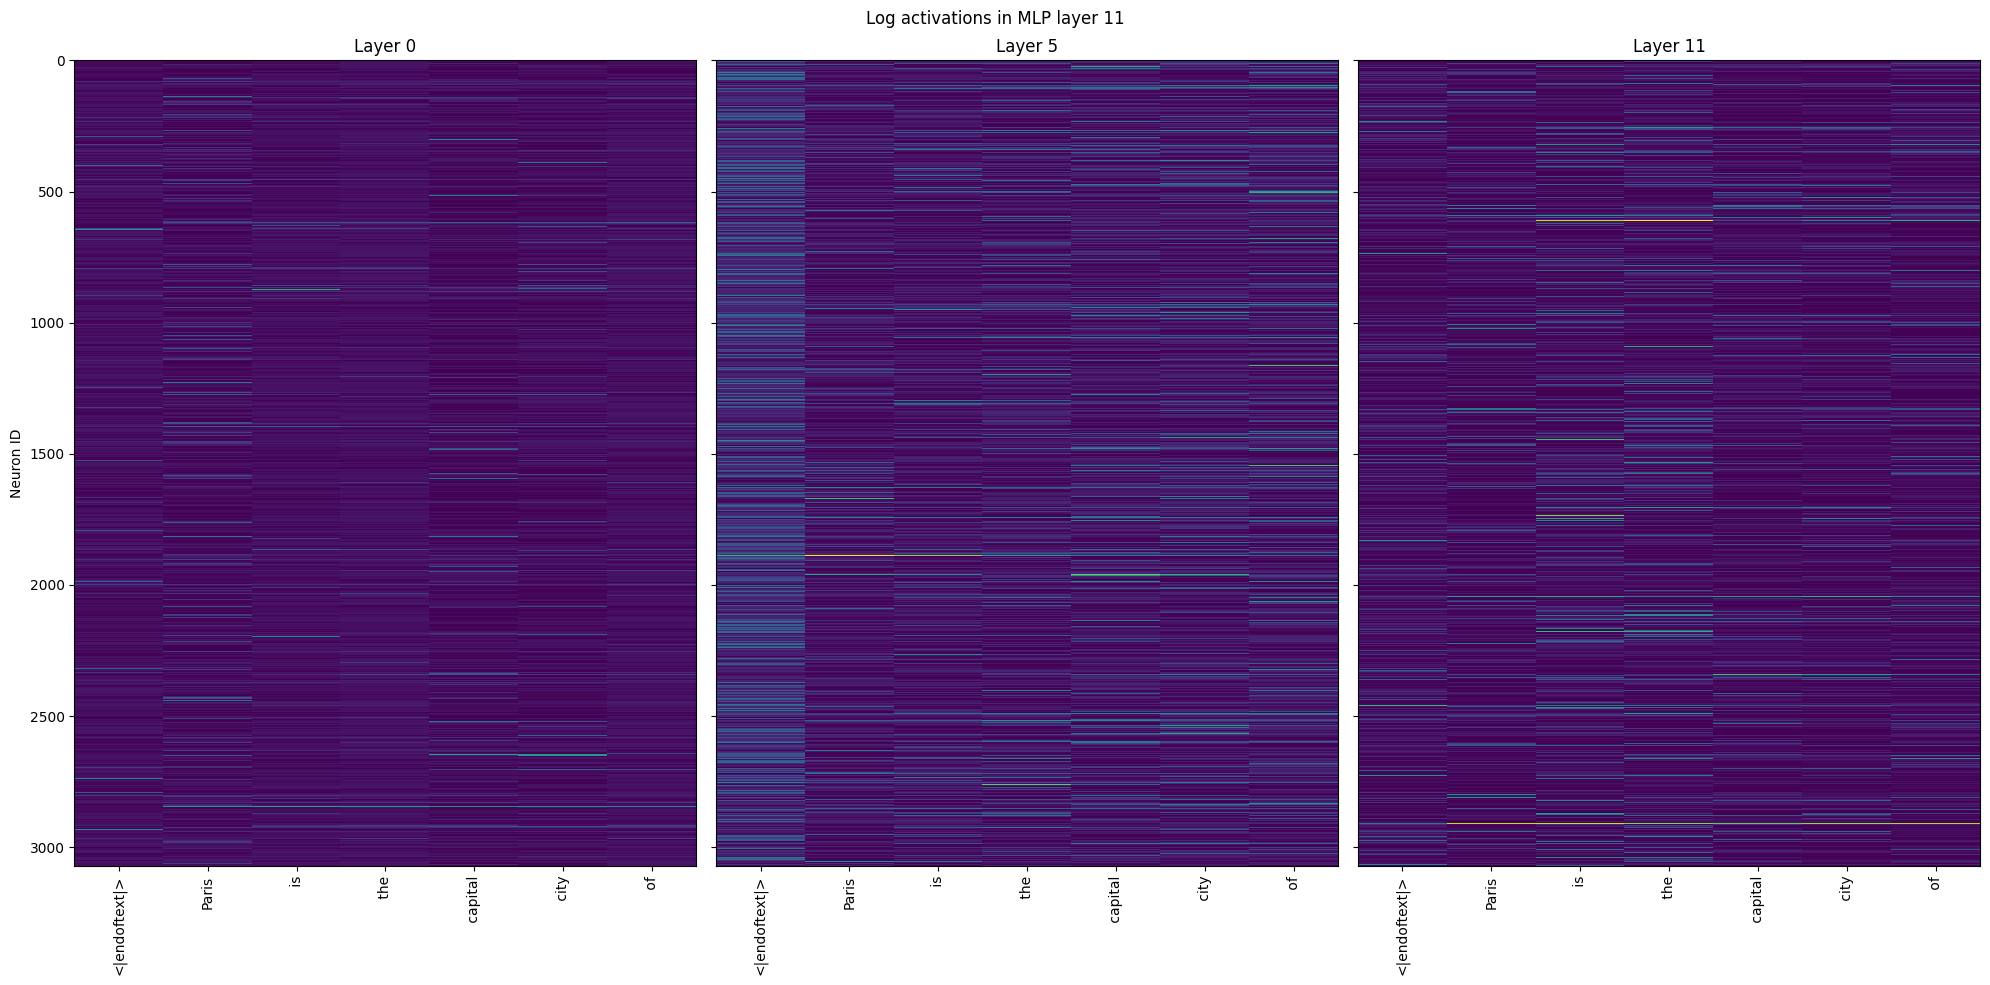

In [83]:
# Get activations for a single layer
layersOfInterest = [0, 5, 11]
fig,ax = plt.subplots(1, len(layersOfInterest), figsize=(20,10),sharey=True)
for l,layer_index in enumerate(layersOfInterest):
    # Get activations
    residual_pre, layer_norm_1, attention, residual_mid, layer_norm_2, mlp, residual_post = layer_activations[layer_index]
    pre_nonlinear, post_nonlinear, out = [mlp[k] for k in ["pre","post","out"]]
    # cur_order = np.argsort(post_nonlinear.mean(axis=0)).tolist()[::-1]
    r = ax[l].imshow(np.log(post_nonlinear.T+1), aspect="auto", interpolation="none")
    r = ax[l].set_xticks(np.arange(n_input_tokens), input_text_str_tokens, rotation="vertical")
    ax[l].set_title(f"Layer {layer_index}")

ax[0].set_ylabel("Neuron ID")
plt.suptitle(f"Log activations in MLP layer {layer_index}")
plt.tight_layout()